In [1]:
import xgboost
import numpy as np
from collections import OrderedDict
import gc
from glob import glob
import os
import pandas as pd
from copy import copy
from time import time
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer
import matplotlib.pyplot as plt
import pickle


/home/wpopiel-ubuwro/miniconda3/envs/xgboost/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# seed for numpy random
np.random.seed(123)

# display all columns of Pandas' dataframes by default
pd.set_option('display.max_columns', None)

data_path = './data/kddcup99_csv.csv'

In [70]:
df =  pd.read_csv(data_path, index_col=False)

# display the first few rows of the dataset
df.head(5)

duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  \
0               0       0    0                  0          1   
1               0       0    0                  0          1   
2               0       0    0                  0          1   
3               0       0    0                  0          1   
4               0       0    0                  0          1   

   lnum_compromised  lroot_shell  lsu_attempted  lnum_root  \
0                 0            0              0          0   
1                 0            0              0          0   
2                 0            0              0          0   
3                 0            0              0          0   
4                 0            0              0          0   

   lnum_file_creations  lnum_shells  lnum_access_files  lnum_outbound_cmds  \
0                    0            0                  0                   0   
1                    0            0                  0                   0   
2                    0            0                  0                   0   
3                    0            0                  0                   0   
4                    0            0                  0                   0   

   is_host_login  is_guest_login  count  srv_count  serror_rate  \
0              0               0      8          8          0.0   
1              0               0      8          8          0.0   
2              0               0      8          8          0.0   
3              0               0      6          6          0.0   
4              0               0      6          6          0.0   

   srv_serror_rate  rerror_rate  srv_rerror_rate  same_srv_rate  \
0              0.0          0.0              0.0            1.0   
1              0.0          0.0              0.0            1.0   
2              0.0          0.0              0.0            1.0   
3              0.0          0.0              0.0            1.0   
4              0.0          0.0              0.0            1.0   

   diff_srv_rate  srv_diff_host_rate  dst_host_count  dst_host_srv_count  \
0            0.0                 0.0               9                   9   
1            0.0                 0.0              19                  19   
2            0.0                 0.0              29                  29   
3            0.0                 0.0              39                  39   
4            0.0                 0.0              49                  49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0                     0.0   
3                     1.0                     0.0   
4                     1.0                     0.0   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.11                          0.0   
1                         0.05                          0.0   
2                         0.03                          0.0   
3                         0.03                          0.0   
4                         0.02                          0.0   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                   0.0   
1                   0.0                       0.0                   0.0   
2                   0.0                       0.0                   0.0   
3                   0.0                       0.0                   0.0   
4                  

In [71]:
pd.DataFrame(df['label'].value_counts())

label
smurf            280790
neptune          107201
normal            97277
back               2203
satan              1589
ipsweep            1247
portsweep          1040
warezclient        1020
teardrop            979
pod                 264
nmap                231
guess_passwd         53
buffer_overflow      30
land                 21
warezmaster          20
imap                 12
rootkit              10
loadmodule            9
ftp_write             8
multihop              7
phf                   4
perl                  3
spy                   2

In [72]:
# here we train a label encoder so that we can map our classes to integers later for model training
le = LabelEncoder()
le.fit(df.label)
print(le.classes_)

['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']


In [73]:
# capture the categorical variables and one-hot encode them
cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']


In [74]:
# find unique labels for each category
cat_data = pd.get_dummies(df[cat_vars])

# check that the categorical variables were created correctly
cat_data.head()

land  logged_in  is_host_login  is_guest_login  protocol_type_icmp  \
0     0          1              0               0                   0   
1     0          1              0               0                   0   
2     0          1              0               0                   0   
3     0          1              0               0                   0   
4     0          1              0               0                   0   

   protocol_type_tcp  protocol_type_udp  service_IRC  service_X11  \
0                  1                  0            0            0   
1                  1                  0            0            0   
2                  1                  0            0            0   
3                  1                  0            0            0   
4                  1                  0            0            0   

   service_Z39_50  service_auth  service_bgp  service_courier  \
0               0             0            0                0   
1               0             0            0                0   
2               0             0            0                0   
3               0             0            0                0   
4               0             0            0                0   

   service_csnet_ns  service_ctf  service_daytime  service_discard  \
0                 0            0                0                0   
1                 0            0                0                0   
2                 0            0                0                0   
3                 0            0                0                0   
4                 0            0                0                0   

   service_domain  service_domain_u  service_echo  service_eco_i  \
0               0                 0             0              0   
1               0                 0             0              0   
2               0                 0             0              0   
3               0                 0             0              0   
4               0                 0             0              0   

   service_ecr_i  service_efs  service_exec  service_finger  service_ftp  \
0              0            0             0               0            0   
1              0            0             0               0            0   
2              0            0             0               0            0   
3              0            0             0               0            0   
4              0            0             0               0            0   

   service_ftp_data  service_gopher  service_hostnames  service_http  \
0                 0               0                  0             1   
1                 0               0                  0             1   
2                 0               0                  0             1   
3                 0               0                  0             1   
4                 0               0                  0             1   

   service_http_443  service_imap4  service_iso_tsap  service_klogin  \
0                 0              0                 0               0   
1                 0              0                 0               0   
2                 0              0                 0               0   
3                 0              0                 0               0   
4                 0              0                 0               0   

   service_kshell  service_ldap  service_link  service_login  service_mtp  \
0               0             0             0              0            0   
1               0             0             0              0            0   
2               0             0             0              0            0   
3               0             0             0              0            0   
4               0             0             0              0            0   

   service_name  service_netbios_dgm  service_netbios_ns  service_netbios_ssn  \
0             0                    0                   0     

In [75]:
numeric_vars = list(set(df.columns.values.tolist()) - set(cat_vars))
numeric_vars.remove('label')
numeric_data = df[numeric_vars].copy()

# check that the numeric data has been captured accurately
numeric_data.head()

lroot_shell  dst_host_same_srv_rate  dst_bytes  dst_host_serror_rate  \
0            0                     1.0       5450                   0.0   
1            0                     1.0        486                   0.0   
2            0                     1.0       1337                   0.0   
3            0                     1.0       1337                   0.0   
4            0                     1.0       2032                   0.0   

   lsu_attempted  same_srv_rate  rerror_rate  dst_host_srv_diff_host_rate  \
0              0            1.0          0.0                          0.0   
1              0            1.0          0.0                          0.0   
2              0            1.0          0.0                          0.0   
3              0            1.0          0.0                          0.0   
4              0            1.0          0.0                          0.0   

   dst_host_rerror_rate  diff_srv_rate  count  lnum_root  urgent  \
0                   0.0            0.0      8          0       0   
1                   0.0            0.0      8          0       0   
2                   0.0            0.0      8          0       0   
3                   0.0            0.0      6          0       0   
4                   0.0            0.0      6          0       0   

   dst_host_diff_srv_rate  hot  lnum_shells  dst_host_srv_count  \
0                     0.0    0            0                   9   
1                     0.0    0            0                  19   
2                     0.0    0            0                  29   
3                     0.0    0            0                  39   
4                     0.0    0            0                  49   

   srv_serror_rate  num_failed_logins  dst_host_count  lnum_compromised  \
0              0.0                  0               9                 0   
1              0.0                  0              19                 0   
2              0.0                  0              29                 0   
3              0.0                  0              39                 0   
4              0.0                  0              49                 0   

   serror_rate  dst_host_srv_rerror_rate  lnum_file_creations  \
0          0.0                       0.0                    0   
1          0.0                       0.0                    0   
2          0.0                       0.0                    0   
3          0.0                       0.0                    0   
4          0.0                       0.0                    0   

   srv_rerror_rate  duration  lnum_outbound_cmds  srv_diff_host_rate  \
0              0.0         0                   0                 0.0   
1              0.0         0                   0                 0.0   
2              0.0         0                   0                 0.0   
3              0.0         0                   0                 0.0   
4              0.0         0                   0                 0.0   

   dst_host_same_src_port_rate  srv_count  dst_host_srv_serror_rate  \
0                         0.11          8                       0.0   
1                         0.05          8                       0.0   
2                         0.03          8                       0.0   
3                         0.03          6                       0.0   
4                         0.02          6                       0.0   

   wrong_fragment  src_bytes  lnum_access_files  
0               0        181                  0  
1               0        239                  0  
2               0        235                  0  
3               0        219                  0  
4               0        217                  0

In [76]:
# concat numeric and the encoded categorical variables
numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)

# here we do a quick sanity check that the data has been concatenated correctly by checking the dimension of the vectors
print(cat_data.shape)
print(numeric_data.shape)
print(numeric_cat_data.shape)

(494020, 84)
(494020, 34)
(494020, 118)


In [77]:
# capture the labels
labels = df['label'].copy()

# convert labels to integers
integer_labels = le.transform(labels)

# split data into test and train
x_train, x_test, y_train, y_test = train_test_split(numeric_cat_data,
                                                    integer_labels,
                                                    test_size=.25, 
                                                    random_state=42)

In [78]:
# check that the dimensions of our train and test sets are okay
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(370515, 118)
(370515,)
(123505, 118)
(123505,)


In [81]:
# save the datasets for later use
preprocessed_data = {
    'x_train':x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test,
    'le':le
}

# pickle the preprocessed_data
path = 'preprocessed_data_full.pkl'
out = open(path, 'wb')
pickle.dump(preprocessed_data, out)
out.close()

In [82]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'normal')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

binary_y_train = convert_label_to_binary(le, y_train)
binary_y_test = convert_label_to_binary(le, y_test)

# check how many anomalies are in our labels
print('Number of anomalies in y_train: ', binary_y_train.sum())
print('Number of anomalies in y_test:  ', binary_y_test.sum())

Number of anomalies in y_train:  297520
Number of anomalies in y_test:   99223


In [83]:
params = {
    'num_rounds':        10,
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'hist',
    'n_gpus':            1,
    'objective':         'binary:logistic',
    'verbose':           True
}

In [84]:
x_train.head(5)

lroot_shell  dst_host_same_srv_rate  dst_bytes  dst_host_serror_rate  \
36198             0                    0.47        361                  0.00   
307313            0                    1.00          0                  0.00   
486986            0                    0.33       3380                  0.02   
206620            0                    1.00          0                  0.00   
300928            0                    1.00          0                  0.00   

        lsu_attempted  same_srv_rate  rerror_rate  \
36198               0            1.0          0.0   
307313              0            1.0          0.0   
486986              0            1.0          0.0   
206620              0            1.0          0.0   
300928              0            1.0          0.0   

        dst_host_srv_diff_host_rate  dst_host_rerror_rate  diff_srv_rate  \
36198                          0.01                   0.0            0.0   
307313                         0.00                   0.0            0.0   
486986                         0.00                   0.0            0.0   
206620                         0.00                   0.0            0.0   
300928                         0.00                   0.0            0.0   

        count  lnum_root  urgent  dst_host_diff_srv_rate  hot  lnum_shells  \
36198       1          0       0                    0.05    0            0   
307313    511          0       0                    0.00    0            0   
486986      1          0       0                    0.06   24            0   
206620    511          0       0                    0.00    0            0   
300928    511          0       0                    0.00    0            0   

        dst_host_srv_count  srv_serror_rate  num_failed_logins  \
36198                  146              0.0                  0   
307313                 255              0.0                  0   
486986                  22              0.0                  0   
206620                 255              0.0                  0   
300928                 255              0.0                  0   

        dst_host_count  lnum_compromised  serror_rate  \
36198              133                 0          0.0   
307313             255                 0          0.0   
486986              66                 0          0.0   
206620             255                 0          0.0   
300928             255                 0          0.0   

        dst_host_srv_rerror_rate  lnum_file_creations  srv_rerror_rate  \
36198                        0.0                    0              0.0   
307313                       0.0                    0              0.0   
486986                       0.0                    0              0.0   
206620                       0.0                    0              0.0   
300928                       0.0                    0              0.0   

        duration  lnum_outbound_cmds  srv_diff_host_rate  \
36198          0                   0                 0.0   
307313         0                   0                 0.0   
486986        64                   0                 0.0   
206620         0                   0                 0.0   
300928         0                   0                 0.0   

        dst_host_same_src_port_rate  srv_count  dst_host_srv_serror_rate  \
36198                          0.01          1                      0.00   
307313                         1.00        511                      0.00   
486986                         0.02          1                      0.05   
206620                         1.00        511                      0.00   
300928                         1.00        511                      0.00   

        wrong_fragment  src_bytes  lnum_access_files  land  logged_in  \
36198                0       1189                  0     0          1   
307313               0       1032                  0     0          0   
486986               0       1205                  0     0  

In [85]:
y_train[:5]

array([11, 18, 11, 18, 18])

In [86]:
%%time 

dtrain = xgboost.DMatrix(x_train, label=binary_y_train)
dtest = xgboost.DMatrix(x_test, label=binary_y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]

/home/wpopiel-ubuwro/miniconda3/envs/xgboost/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 9.46 s, sys: 2.21 s, total: 11.7 s
Wall time: 3.51 s


In [87]:
num_rounds = params['num_rounds']

In [88]:
model = xgboost.train(params, dtrain, num_rounds, evals=evals)

[11:42:51] WARNING: ../src/learner.cc:576: 
Parameters: { "n_gpus", "num_rounds", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:42:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.59847	train-logloss:0.59832
[1]	test-logloss:0.52088	train-logloss:0.52066
[2]	test-logloss:0.45622	train-logloss:0.45585
[3]	test-logloss:0.40143	train-logloss:0.40118
[4]	test-logloss:0.35475	train-logloss:0.35450
[5]	test-logloss:0.31448	train-logloss:0.31433
[6]	test-logloss:0.27951	train-logloss:0.27929
[7]	test-logloss:0.24905	train-loglos

In [89]:
threshold = .5
true_labels = binary_y_test.astype(int)
true_labels.sum()

99223

In [90]:
# make predictions on the test set using our trained model
preds = model.predict(dtest)
print(preds)

[0.82071537 0.82071537 0.8160451  ... 0.82071537 0.82071537 0.18002099]


In [91]:
pred_labels = (preds > threshold).astype(int)
print(pred_labels)

[1 1 1 ... 1 1 0]


In [92]:
pred_labels.sum()

99225

In [93]:
# compute the auc
auc = roc_auc_score(true_labels, preds)
print(auc)

0.9999348705606802


In [94]:
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Accuracy: 0.9993684466215943


Confusion Matrix :


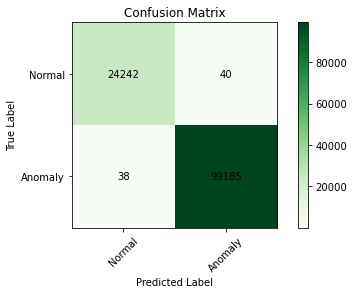

In [95]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

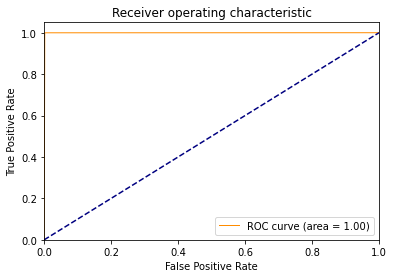

In [96]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

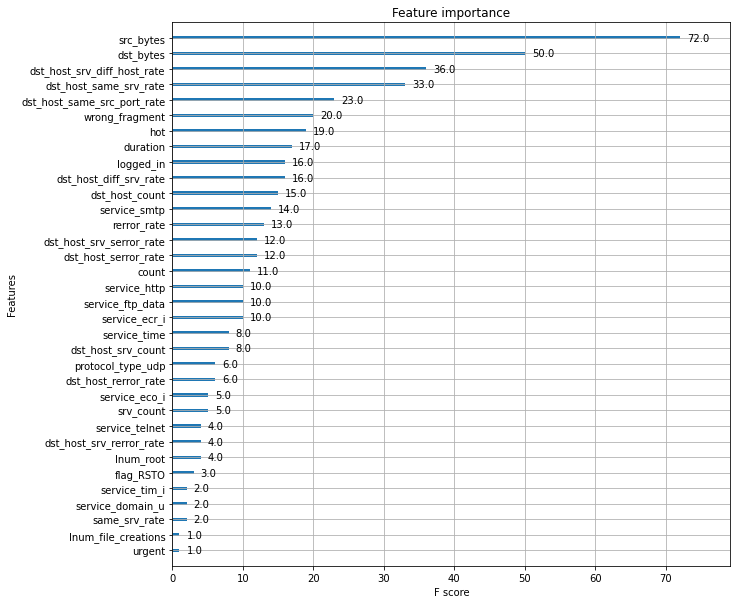

In [97]:
ax = xgboost.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

In [43]:
def reduce_anomalies(df, pct_anomalies=.01):
    labels = df['label'].copy()
    is_anomaly = labels != 'normal'
    num_normal = np.sum(~is_anomaly)
    num_anomalies = int(pct_anomalies * num_normal)
    all_anomalies = labels[labels != 'normal']
    anomalies_to_keep = np.random.choice(all_anomalies.index, size=num_anomalies, replace=False)
    anomalous_data = df.iloc[anomalies_to_keep].copy()
    normal_data = df[~is_anomaly].copy()
    new_df = pd.concat([normal_data, anomalous_data], axis=0)
    return new_df

In [44]:
df = reduce_anomalies(df)

In [45]:
pd.DataFrame(df['label'].value_counts())

label
normal       97277
smurf          698
neptune        248
teardrop         7
satan            5
back             5
warezclient      3
ipsweep          2
portsweep        2
rootkit          1
pod              1

Go back to train and validate model after reduction.

In [98]:
num_labels = len(le.classes_)
params['objective'] = 'multi:softprob'
params['num_class'] = num_labels
print(params)

{'num_rounds': 10, 'max_depth': 8, 'max_leaves': 256, 'alpha': 0.9, 'eta': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'subsample': 1, 'reg_lambda': 1, 'scale_pos_weight': 2, 'tree_method': 'hist', 'n_gpus': 1, 'objective': 'multi:softprob', 'verbose': True, 'num_class': 23}


In [99]:
dtrain = xgboost.DMatrix(x_train, label=y_train)
dtest = xgboost.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]

/home/wpopiel-ubuwro/miniconda3/envs/xgboost/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [100]:
model = xgboost.train(params, dtrain, num_rounds, evals=evals)

[11:49:59] WARNING: ../src/learner.cc:576: 
Parameters: { "n_gpus", "num_rounds", "scale_pos_weight", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:50:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-mlogloss:2.03401	train-mlogloss:2.03480
[1]	test-mlogloss:1.67044	train-mlogloss:1.66933
[2]	test-mlogloss:1.42197	train-mlogloss:1.42190
[3]	test-mlogloss:1.23283	train-mlogloss:1.23202
[4]	test-mlogloss:1.08049	train-mlogloss:1.08079
[5]	test-mlogloss:0.95438	train-mlogloss:0.95381
[6]	test-mlogloss:0.84716	train-mlogloss:0.84725
[7

In [101]:
preds = model.predict(dtest)

In [102]:
pred_labels = np.argmax(preds, axis=1)

In [103]:
pred_labels

array([18, 18,  9, ..., 18, 18, 11])

In [104]:
true_labels = y_test
true_labels

array([18, 18,  9, ..., 18, 18, 11])

In [105]:
print ('Accuracy Score :', accuracy_score(true_labels, pred_labels))

Accuracy Score : 0.9994494150034412


Confusion Matrix :


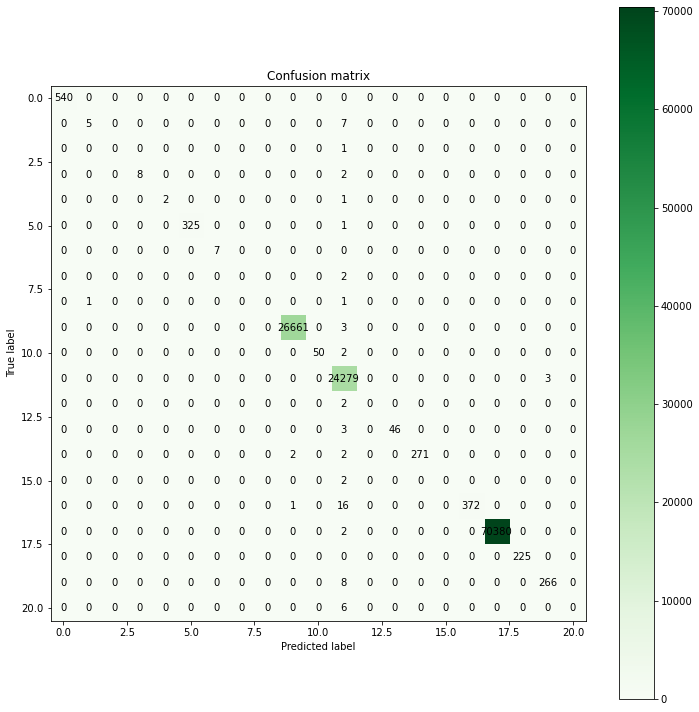

In [106]:
cm = confusion_matrix(true_labels, pred_labels)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    #tick_marks = np.arange(len(target_names))
    #plt.xticks(tick_marks, target_names, rotation=45)
    #plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)